# Naïve Bayes Modeling

## Predicting the Character

In [1]:
#Importing necessary Libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

#Import Naive Bayes 
from sklearn.naive_bayes import MultinomialNB

#Other libraries needed 
from sklearn.metrics import (plot_confusion_matrix, accuracy_score, 
                             f1_score, classification_report)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

In [2]:
#import the dataset
friends = pd.read_csv('../../Datasets/friends-modeling.csv')
friends.head()

,season,episode,character,dialogue
0,s01,e01,Monica Geller,There's nothing to tell! He's just some guy I ...
1,s01,e01,Joey Tribbiani,"C'mon, you're going out with the guy! There's ..."
2,s01,e01,Chandler Bing,"All right Joey, be nice. So does he have a hum..."
3,s01,e01,Phoebe Buffay,"Wait, does he eat chalk?"
4,s01,e01,Phoebe Buffay,"Just, 'cause, I don't want her to go through w..."


In [3]:
#Make sure no nulls
friends.isnull().sum()

season       0
episode      0
character    0
dialogue     0
dtype: int64

### Make X and y values 

In [4]:
X = friends['dialogue']
y = friends['character']

### Split into Train and Test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [6]:
X_train.shape

(38472,)

In [7]:
y_train.shape

(38472,)

In [8]:
X_test.shape

(12825,)

In [9]:
y_test.shape

(12825,)

### Baseline Accuracy 

In [10]:
y_train.value_counts(normalize=True)

Rachel Green      0.181847
Ross Geller       0.178571
Chandler Bing     0.167031
Monica Geller     0.165627
Joey Tribbiani    0.160012
Phoebe Buffay     0.146912
Name: character, dtype: float64

### Setting up a Pipe for all Naïve Bayes Modeling

In [11]:
# Get the same accuracy and scores 
np.random.seed(42)

In [12]:
pipe = Pipeline(steps=[('cv', CountVectorizer()),
                       ('mnb', MultinomialNB())
                      ])

### Modeling: Basic Model with Default Parameters and using CountVectorizer

In [32]:
grid_d = {'cv__stop_words':[None, 'english'],
               'cv__min_df': [0, 1, 2]}

In [33]:
# Instaniate a gridSearch object 
gs_d = GridSearchCV(estimator=pipe, param_grid=grid_d)
gs_d.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cv__min_df': [0, 1, 2],
                         'cv__stop_words': [None, 'english']})

In [34]:
gs_d.best_params_

{'cv__min_df': 0, 'cv__stop_words': None}

In [35]:
gs_d.score(X_train, y_train), gs_d.score(X_test, y_test)

(0.45518818881264295, 0.296140350877193)

In [36]:
gs_d.best_score_

0.29190070218340136

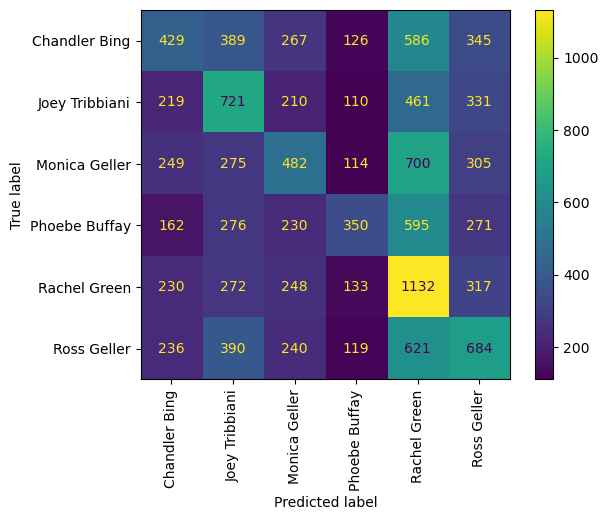

In [18]:
plot_confusion_matrix(estimator=gs_d, X = X_test, y_true=y_test)
plt.xticks(rotation = 90)
plt.show()

In [19]:
preds_d = gs_d.predict(X_test)

In [20]:
print(classification_report(y_true=y_test, y_pred=preds_d))

                precision    recall  f1-score   support

 Chandler Bing       0.28      0.20      0.23      2142
Joey Tribbiani       0.31      0.35      0.33      2052
 Monica Geller       0.29      0.23      0.25      2125
 Phoebe Buffay       0.37      0.19      0.25      1884
  Rachel Green       0.28      0.49      0.35      2332
   Ross Geller       0.30      0.30      0.30      2290

      accuracy                           0.30     12825
     macro avg       0.30      0.29      0.29     12825
  weighted avg       0.30      0.30      0.29     12825



In [21]:
nb_d = pd.DataFrame(y_test)

nb_d['predictions'] = preds_d

nb_d['dialogue'] = X_test

nb_d.rename(columns={'character': 'actual'}, inplace=True)
nb_d.head(10)

,actual,predictions,dialogue
45809,Rachel Green,Monica Geller,"When you're sick, you do whatever you can to m..."
27777,Rachel Green,Rachel Green,"Well then honey, buy the lamp! Hey, we have th..."
48256,Rachel Green,Ross Geller,She's mine!
36522,Monica Geller,Monica Geller,"Did I miss it? Rachel, I-I want you to know th..."
6393,Phoebe Buffay,Phoebe Buffay,"OK, look, see, this is him. My mother gave me ..."
25997,Rachel Green,Chandler Bing,"But y'know what, if you think it's gonna be ok..."
16641,Chandler Bing,Ross Geller,"Well, like father, like son."
16009,Chandler Bing,Chandler Bing,Could be Casey.
48797,Joey Tribbiani,Rachel Green,"Oh, I know how you feel..."
6594,Monica Geller,Chandler Bing,Bobby.


In [22]:
nb_d.loc[nb_d['actual']!= nb_d['predictions']].count()

actual         9027
predictions    9027
dialogue       9027
dtype: int64

----
### Trying with Parameters!

In [44]:
grid_1 = {'cv__stop_words':[None, 'english'],
          'mnb__alpha': np.linspace(0.5, 0.9, 3),
          'mnb__fit_prior': [True, False]
         }

In [45]:
gs_1 = GridSearchCV(estimator=pipe, param_grid=grid_1)
gs_1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cv__stop_words': [None, 'english'],
                         'mnb__alpha': array([0.5, 0.7, 0.9]),
                         'mnb__fit_prior': [True, False]})

In [46]:
gs_1.best_params_

{'cv__stop_words': None, 'mnb__alpha': 0.9, 'mnb__fit_prior': False}

In [47]:
gs_1.score(X_train, y_train), gs_1.score(X_test, y_test)

(0.45812538989394885, 0.29676413255360623)

In [48]:
gs_1.best_score_

0.293642237953914

In [51]:
np.linspace(0.5, 1.5, 6)

array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5])

In [43]:
np.linspace(0.5, 0.9, 3)

array([0.5, 0.7, 0.9])

----
#### More hyperparameter tuning!

In [52]:
grid_2 = {'cv__stop_words':[None, 'english'],
          'mnb__alpha': np.linspace(0.5, 1.5, 6),
          'mnb__fit_prior': [True, False]
         }

In [53]:
gs_2 = GridSearchCV(estimator=pipe, param_grid=grid_2)
gs_2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cv__stop_words': [None, 'english'],
                         'mnb__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                         'mnb__fit_prior': [True, False]})

In [54]:
gs_2.best_params_

{'cv__stop_words': None, 'mnb__alpha': 1.1, 'mnb__fit_prior': False}

In [55]:
gs_2.score(X_train, y_train), gs_2.score(X_test, y_test)

(0.4538105635267207, 0.295906432748538)